<a href="https://colab.research.google.com/github/ShotaArima/task-wind-to-ep/blob/main/Final_Task(iwano_ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# モジュールのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.api.models import Sequential
from keras.api.layers import Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
# データの読み込み
f = open('/content/drive/MyDrive/class/知能科学/wind_data_s.csv')
df = pd.read_csv(f)
xy = df.loc[:,['x1', 'x2', 'y']].values

In [4]:
# データの正規化
scaler = MinMaxScaler()
norm_xy = scaler.fit_transform(xy)
#print(norm_xy)

# 学習データと評価データの準備
norm_x = norm_xy[:, 0:2]
norm_y = norm_xy[:, 2]
x_train = norm_x[:304]
x_test = norm_x[304:440]
y_train = norm_y[:304]
y_test = norm_y[304:440]
#print(x_train)
#print(x_train.shape)
#print(y_train)
#print(y_train.shape)
#print(x_test)
#print(x_test.shape)
#print(y_test)
#print(y_test.shape)

In [5]:
# ニューラルネットワークの構築
input_nnode = 2    # 入力層のノード数
mid1_nnode = 4     # １番目の中間層のノード数
#mid2_nnode = 2     # ２番目の中間層のノード数
output_nnode = 1   # 出力層のノード数
model = Sequential()
model.add(Dense(mid1_nnode, activation='relu', input_dim=input_nnode))
#model.add(Dense(mid2_nnode, activation='relu'))
model.add(Dense(output_nnode, activation='linear'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# ネットワークの最適化（学習）
model.compile(optimizer='adam',
   loss='mean_squared_error',
   metrics=['mean_absolute_error'])

train_history = model.fit(x_train, y_train,
   batch_size=8,
   epochs=300,
   verbose=1,
   validation_data=(x_test, y_test))

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0316 - mean_absolute_error: 0.1079 - val_loss: 0.0054 - val_mean_absolute_error: 0.0495
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0185 - mean_absolute_error: 0.0860 - val_loss: 0.0079 - val_mean_absolute_error: 0.0765
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0292 - mean_absolute_error: 0.1147 - val_loss: 0.0072 - val_mean_absolute_error: 0.0725
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0222 - mean_absolute_error: 0.1061 - val_loss: 0.0068 - val_mean_absolute_error: 0.0705
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0211 - mean_absolute_error: 0.0999 - val_loss: 0.0061 - val_mean_absolute_error: 0.0660
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - mean_absolute_error: 0.0857 - val_loss: 0.0058 - val_mean_absolute_error: 0.0644
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - mean_absolute_error: 0.0857 - val_l

{'loss': [0.03418071195483208, 0.023310357704758644, 0.021975625306367874, 0.020917827263474464, 0.019785843789577484, 0.018778864294290543, 0.017799947410821915, 0.016848117113113403, 0.01602904126048088, 0.015153047628700733, 0.014393560588359833, 0.013624644838273525, 0.012962034903466702, 0.01240641251206398, 0.01188528910279274, 0.011418215930461884, 0.011037369258701801, 0.010691971518099308, 0.010309744626283646, 0.010023596696555614, 0.009672239422798157, 0.00941783282905817, 0.009264657273888588, 0.008910374715924263, 0.008687418885529041, 0.008411123417317867, 0.008169648237526417, 0.008012667298316956, 0.007723764982074499, 0.007574814837425947, 0.007361383177340031, 0.007213107775896788, 0.006982541177421808, 0.006870196666568518, 0.006705934181809425, 0.006447204854339361, 0.006354270502924919, 0.006177371833473444, 0.005968947429209948, 0.005860397592186928, 0.005732980091124773, 0.00559521047398448, 0.005556335672736168, 0.005355972796678543, 0.005252707749605179, 0.0051

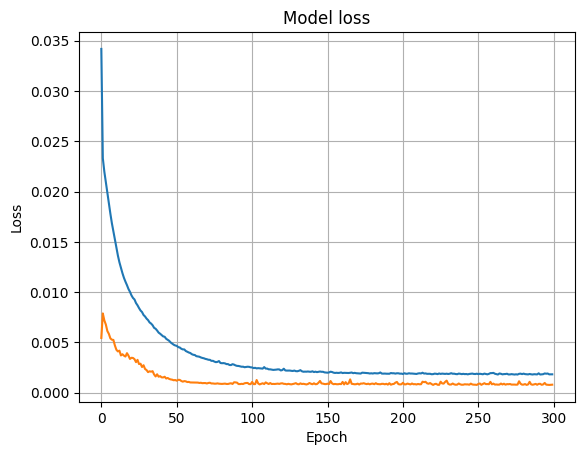

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[ 5.95155621 12.4714191   5.26216829  4.66426921  4.20448625  3.33095264
 21.90067804  7.56917691 13.03427231  5.26216829  8.69489706  8.13203835
  3.56114709  5.30760837  3.88281667  4.5261668   1.30765593  0.15849602
  2.50286186  4.43407202  5.03199303  3.00928307  1.12409973  2.18119228
  2.31930292  3.56054938  3.69866276  4.11241066  3.74470055  3.28491485
  3.65261811  4.11241066 -0.11774856  1.26161814  3.88221484  4.57220185
  5.03199303  4.2505213   4.15844846  9.07012522  6.15121233 -2.00293326
 -1.40502048  1.53724718  4.34199917  3.79074383  3.69866276  0.80243015
  0.80183518  3.00868261  1.17013478  1.76743615  2.68701303  3.19283789
  2.41138399  2.31930292  1.76743615  2.27326787  2.73305082  1.95159829
  3.51451159  5.35365164  3.88281667  1.21617806  1.53724718  3.51451159
  4.93991196  4.2505213   5.39969218  5.53781104  5.53781104 20.96258843
 44.93513715 27.20233393  6.27383173  5.58384609  1.81408536 -0.25525737
 -2.50814807 

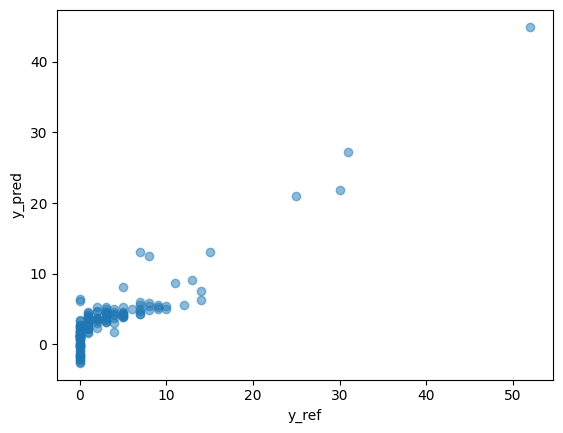

In [7]:
# 学習経過の表示
train_history.history.keys()
print(train_history.history)
len(train_history.history['loss'])

# 損失関数値のプロット
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

# 評価データによる推定と逆正規化
norm_y_pred = model.predict(x_test)
#print(norm_y_pred)
norm_xy_pred = np.hstack((x_test, norm_y_pred))
xy_pred = scaler.inverse_transform(norm_xy_pred)

# 最終的な推定値と正解値の表示
y_pred = xy_pred[:, 2]
y_ref = xy[304:440, 2]
print(y_pred)
print(y_ref)
fig, ax = plt.subplots()
ax.scatter(y_ref, y_pred, alpha=0.5)
ax.set_xlabel('y_ref')
ax.set_ylabel('y_pred')
plt.show()